In [3]:
import pandas as pd
import random
import numpy as np

# Data acquisition 

We downloaded the OAA and WOBA data from Baseball Savant https://baseballsavant.mlb.com and provide the code for merging the different dataframes in the cell below. For pitching data, we scraped baseball reference, where the code can be found in scraping.py. For any additional information about the data or code, please look at our Github repository attached here https://github.com/jackdpond/snare_algo 


In [6]:
# read in combined OAA data
oaa = pd.read_csv('data/outs_above_average-20.csv')
oaa = oaa.rename(columns={'team_name': 'team'})

# read in expected stats for each year
expected_files = [
    'data/expected_stats.csv',
    'data/expected_stats-2.csv',
    'data/expected_stats-3.csv',
    'data/expected_stats-4.csv',
    'data/expected_stats-5.csv',
    'data/expected_stats-6.csv',
    'data/expected_stats-7.csv',
    'data/expected_stats-8.csv',
    'data/expected_stats-9.csv',
    'data/expected_stats-10.csv',
]
expected_stats_list = [pd.read_csv(f) for f in expected_files]
expected_stats_combined = pd.concat(expected_stats_list, ignore_index=True)

# read in wildcard data and normalize columns
wildcard_df = pd.read_csv('data/wildcard.csv')
wildcard_df = wildcard_df.rename(columns={'Year': 'year', 'Team': 'team'})

# merge OAA and expected stats
merged_df = pd.merge(oaa, expected_stats_combined, on=['team', 'year'], how='left')

# merge with wildcard data
merged_df = pd.merge(merged_df, wildcard_df, on=['team', 'year'], how='left', indicator=True)

# create is_wildcard column
merged_df['is_wildcard'] = (merged_df['_merge'] == 'both').astype(int)

# clean up
merged_df.drop(columns=['_merge'], inplace=True)
merged_df.drop(columns=['team_id_x', 'primary_pos_formatted'], errors='ignore', inplace=True)

This took care of the data acquisition for the OAA and WOBA data. For pitching data, we scraped baseball reference. To see the code for scraping, please look at scraping.py. 

# Data Cleaning

In [22]:

def clean_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert columns to correct data types, add game_id and freshness columns, delete unneeded rows and fill missing values.
    This function cleans the pitcher logs dataframes.

    Paramaters:
        df (pd.DataFrame): A pitchers' log dataframe with all of the associated columns

    Returns: A cleaned df ready to use to create the dataframe of games.
    """
    # Drop rows without a value for pitcher Id. They are un-useable as we can't match them to other games
    df.dropna(subset='Id', inplace=True)

    # Convert Date column to pd.datetime object and add a year column
    df['Date'] = pd.to_datetime(df['Date'].astype(str).str.split().str[0])
    df['year'] = df['Date'].dt.year

    # Add a binary, one-hot encode feature representing whether the pitcher pitched the Game Start (GS)
    df['opener'] = df['Inngs'].astype(str).str.contains('GS', na=False)

    # Add game_id column/feature, made up of [alphabetically first team] + [alphabetically last team] + [date]
    # Thus we have a unique game id for each game
    df['ateam'] = df[['Team', 'Opp']].min(axis=1)
    df['zteam'] = df[['Team', 'Opp']].max(axis=1)
    df['game_id'] = df['ateam'] + '_' + df['zteam']  + '_' + df['Date'].dt.strftime('%Y-%m-%d')

    # Sort the dataframe by pitcher id and then by date. 
    # This line sorts the dataframe into blocks, one for each pitcher, each of which is sorted by date
    df = df.sort_values(['Id', 'Date'])

    # Get the freshness column by finding time between games
    df['prev_game'] = df.groupby('Id')['Date'].shift(1)
    df['freshness'] = df['Date'] - df['prev_game']

    # First games will have NaN; fill with max freshness
    max_freshness = df['freshness'].max()
    df['freshness'] = df['freshness'].fillna(max_freshness)

    # Convert FIP column to numeric
    df['FIP'] = df['FIP'].apply(pd.to_numeric, errors='coerce')

    # Rename team column in order to merge later
    df.rename(columns={'Team': 'team',}, inplace=True)

    # Naming of one team switched in 2024; switch it to the old name to be consistent
    rid_ath = lambda x: x if x != "ATH" else "OAK"
    df['team'] = df['team'].apply(rid_ath)

    # Return new cleaned df
    return df


def merge_with_meta(df: pd.DataFrame, mdf: pd.DataFrame) -> pd.DataFrame:
    """
    Merge the granular, pitcher-log dataset with the dataset of team level info.

    Parameters:
        df (pd.DataFrame): A dataframe of pitchers' log information
        mdf (pd.DataFrame): 'cleaned_team_data.csv' as a dataframe

    Returns: A merged dataframe on team and year
    """
    return df.merge(mdf, on=['team', 'year'])

def get_rs_record(rsdf, psdf):
    """
    Add a regular season record column to the post_season dataset, to test another idea. We didn't end up using this.
    We left it in because we are proud of it.
    """
    df = rsdf.copy()
    df['Record'] = df.groupby(['Team', 'Year'])['Result'].transform(
    lambda x: x.sum() / len(x)
    )
    season_records = (
        df
        .groupby(["Team", "Year"])["Result"]
        .mean()
        .reset_index()
        .rename(columns={"Result": "WinPct"})
    )
    psdf = psdf.merge(season_records, on=["Team", "Year"], how="left")


def assemble_game_df(df: pd.DataFrame, post_season: bool=False):
    """
    This is the function that does a lot of the heavy lifting. Its purpose is to take a dataframe where each row represents a pitcher's performance
    for one game, and reorganize it so each row represents a game, containing data for both teams.

    Parameters:
        df (pd.DataFrame): A dataframe with each row containing data for a single pitcher's game. The info includes both pitcher's log info and team
                            level info.
        post_season (bool): Boolean for whether the dataframe contains info for post-season games. If so, the wild-card columns are made differently.

    Returns: A datafame with game-level data for both teams in the game.
    """
    # Create a list of columns to be included in the final dataset--this will be used to create row dictionaries. Create empty list to hold rows
    game_cols = ["game_id", "1_opener_fip", "1_opener_freshness", "1_others_fip", "1_others_freshness", "1_woba", "1_ooa", "1_home", "1_team", "1_is_wildcard", "2_opener_fip", "2_opener_freshness", "2_others_fip", "2_others_freshness", "2_woba", "w_ooa", "2_team", "2_is_wildcard", "is_playoff", "result"]
    game_rows = []

    # Create label_map for creating the results column
    label_map = {'W': 1,
                'L': 0,
                'T': 2}

    # Iterate through each game in the dataframe
    for game_id, game_group in df.groupby('game_id'):
        # Create empty list to hold a stats dictionary for each team in this game
        teams_data = []

        # Iterate through the two teams in the game
        for team, team_group in game_group.groupby('team'):
            # Get a df (one row) for the starter pitcher and a df for the relief pitchers
            opener_df = team_group[team_group['opener']]
            others_df = team_group[~team_group['opener']]

            # If either are empty, abort for this row and continue to the next game
            if opener_df.empty or others_df.empty:
                break 

            # Get FIP and freshness of starting pitcher
            opener_fip = opener_df['FIP'].mean()
            opener_fresh = opener_df['freshness'].mean()

            # Get averaged FIP and freshness of relief pitchers
            others_fip = others_df['FIP'].mean()
            others_fresh = others_df['freshness'].mean()

            # Backup check to make sure "ATH" doesn't make it in. Redundant after cleaning.
            team_name = team if team != "ATH" else "OAK"

            # Create dictionary containing this team's stats for the game
            team_data = {
                "opener_fip": opener_fip,
                "opener_freshness": opener_fresh.total_seconds() / 3600,    # Divide freshness by seconds to get days
                "others_fip": others_fip,
                "others_freshness": others_fresh.total_seconds() / 3600,
                "home": 1 if team_group.iloc[0]['Home'] == '@' else 0,      # Create indicator of home or away
                "team": team_name,
                "result": label_map[team_group.iloc[0]['Result'][0]],       # Use label map to create result indicator
                "woba": team_group.iloc[0]['woba'],
                "ooa": team_group.iloc[0]['outs_above_average'],
                "is_wildcard": team_group.iloc[0]['is_wildcard'] if post_season else 0 # Only consider wild-card if post-season game
            }

            # Add stats dictionary to teams_data list.
            teams_data.append(team_data)

        # If there were somehow more or less than 2 teams, continue to the next game.
        if len(teams_data) != 2:
            continue

        # Shuffle the teams randomly so the models don't get skewed
        random.shuffle(teams_data)
        team1, team2 = teams_data

        # Indicator for whether the game is postseason or not
        is_playoff = 1 if post_season else 0

        # Create row representing the data for the game.
        game_data = [
        game_id,
        team1["opener_fip"], team1["opener_freshness"],
        team1["others_fip"], team1["others_freshness"],
        team1["woba"],       team1["ooa"],
        team1["home"],       team1["team"],
        team1["is_wildcard"],
        team2["opener_fip"], team2["opener_freshness"],
        team2["others_fip"], team2["others_freshness"],
        team2["woba"],       team2["ooa"],
        team2["team"],
        team2["is_wildcard"], 
        is_playoff,
        team1["result"]
        ]

        # Append to list of game_rows
        game_rows.append(dict(zip(game_cols, game_data)))

    # Assemble all game rows into dataframe
    games_df = pd.DataFrame(game_rows)

    # Return final dataframe
    return games_df

def get_game_df(df, mdf, post_season=False):
    """
    Final helper function to pull everything together. This takes in necessary pieces (pitchers' logs, meta data), and assembles it into
    a games dataframe.

    Parameters:
        df (pd.DataFrame): A dataframe of pitchers' log information
        mdf (pd.DataFrame): 'cleaned_team_data.csv' as a dataframe

    Returns: A cleaned, assembled games dataframe.
    """
    cleaned = clean_df(df)
    merged = merge_with_meta(cleaned, mdf=mdf)
    games_df = assemble_game_df(merged, post_season=post_season)

    return games_df

In [23]:
# Read in post-season pitchers' logs from the csv
psdf = pd.read_csv('data/ps_pitcher_logs.csv')

# Get rid of headliner rows that don't match format
psdf.dropna(subset=['Gcar'], inplace=True)

# Status
print("Post season dataset has been read successfully")

# Each year of regular season data is separate. The following loop concatenates them all into one df.
# Start with empty list to hold all dataframes
dfs = []

# Iterate through each year in the given range
for year in range(14, 26):
    # No data could be pulled for 2024. Skip this year.
    if year == 24:
        continue
    
    # Create formatted string with correct name and read in csv
    file_path = f"data/pitcher_log_20{year}.csv"
    year_df = pd.read_csv(file_path, parse_dates=['Date']) # Make 'Date' a datetime object

    # Get rid of headliner rows
    year_df = year_df[~year_df['Gcar'].isna()]

    # Append to list of logs
    dfs.append(year_df)

# Concatenate all pitchers' log dataframes into one regular season dataframe
rsdf = pd.concat(dfs, ignore_index=True)

# Status
print("Regular season dataset has been read successfully")

# The team names don't match in the pitchers' logs and the team-lvel dataframe. Make a map to match them
team_map = {
    'Angels': 'LAA',
    'Astros': 'HOU',
    'Athletics': 'OAK',
    'Blue Jays': 'TOR',
    'Braves': 'ATL',
    'Brewers': 'MIL',
    'Cardinals': 'STL',
    'Cubs': 'CHC',
    'D-backs': 'ARI',
    'Dodgers': 'LAD',
    'Giants': 'SFG',
    'Guardians': 'CLE',
    'Mariners': 'SEA',
    'Marlins': 'MIA',
    'Mets': 'NYM',
    'Nationals': 'WSN',
    'Orioles': 'BAL',
    'Padres': 'SDP',
    'Phillies': 'PHI',
    'Pirates': 'PIT',
    'Rangers': 'TEX',
    'Rays': 'TBR',
    'Red Sox': 'BOS',
    'Reds': 'CIN',
    'Rockies': 'COL',
    'Royals': 'KCR',
    'Tigers': 'DET',
    'Twins': 'MIN',
    'White Sox': 'CHW',
    'Yankees': 'NYY'
}

# Create a function to switch team names to match
switcher = lambda x: team_map[x]

# Read in team-level dataset and make the names match
metadf = pd.read_csv('data/cleaned_team_data.csv')
metadf = metadf[['team', 'year', 'outs_above_average', 'woba', 'is_wildcard']]
metadf['team'] = metadf['team'].apply(switcher)

# Status
print("Team level dataset has been read successfully")

Post season dataset has been read successfully
Regular season dataset has been read successfully
Team level dataset has been read successfully


In [24]:
# Get post-season games dataframe
ps_games_df = get_game_df(psdf, metadf, post_season=True)

# Get regular-season games dataframe
rs_games_df = get_game_df(rsdf, metadf)

# Concatenate them into the final dataset
games_df = pd.concat([ps_games_df, rs_games_df])

# Status
print("Successfully assembled Games dataset")

Successfully assembled Games dataset


In [25]:
# Some final cleaning
# Get all woba scores mean them
all_wobas = games_df['1_woba'].dropna().tolist() + games_df['2_woba'].dropna().tolist()
mean_woba = np.mean(np.array(all_wobas))

# Fill NaN values with mean woba scores
games_df['1_woba'] = games_df['1_woba'].fillna(mean_woba)
games_df['2_woba'] = games_df['2_woba'].fillna(mean_woba)

# There is one missing value for 2_opener_fip; drop it.
games_df.dropna(subset=['2_opener_fip'], inplace=True)

# Save final dataframe!
games_df.to_csv('data/GAMES.csv', index=False)

# Status
print("Games DataFrame cleaned and saved successfully!")

Games DataFrame cleaned and saved successfully!


# Exploratory Data Analysis

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({
    "font.size": 12,          # default text size
    "axes.labelsize": 12,     # axis labels
    "xtick.labelsize": 12,    # tick labels
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "axes.titlesize": 14,     # <--- titles
})

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 300 

In [ ]:
# Read in dataset and convert columns to datetime where useful.
df = pd.read_csv('data/GAMES.csv')
df['date'] = pd.to_datetime(df['game_id'].str.extract(r'(\d{4}-\d{2}-\d{2})')[0])
df['year'] = df['date'].dt.year

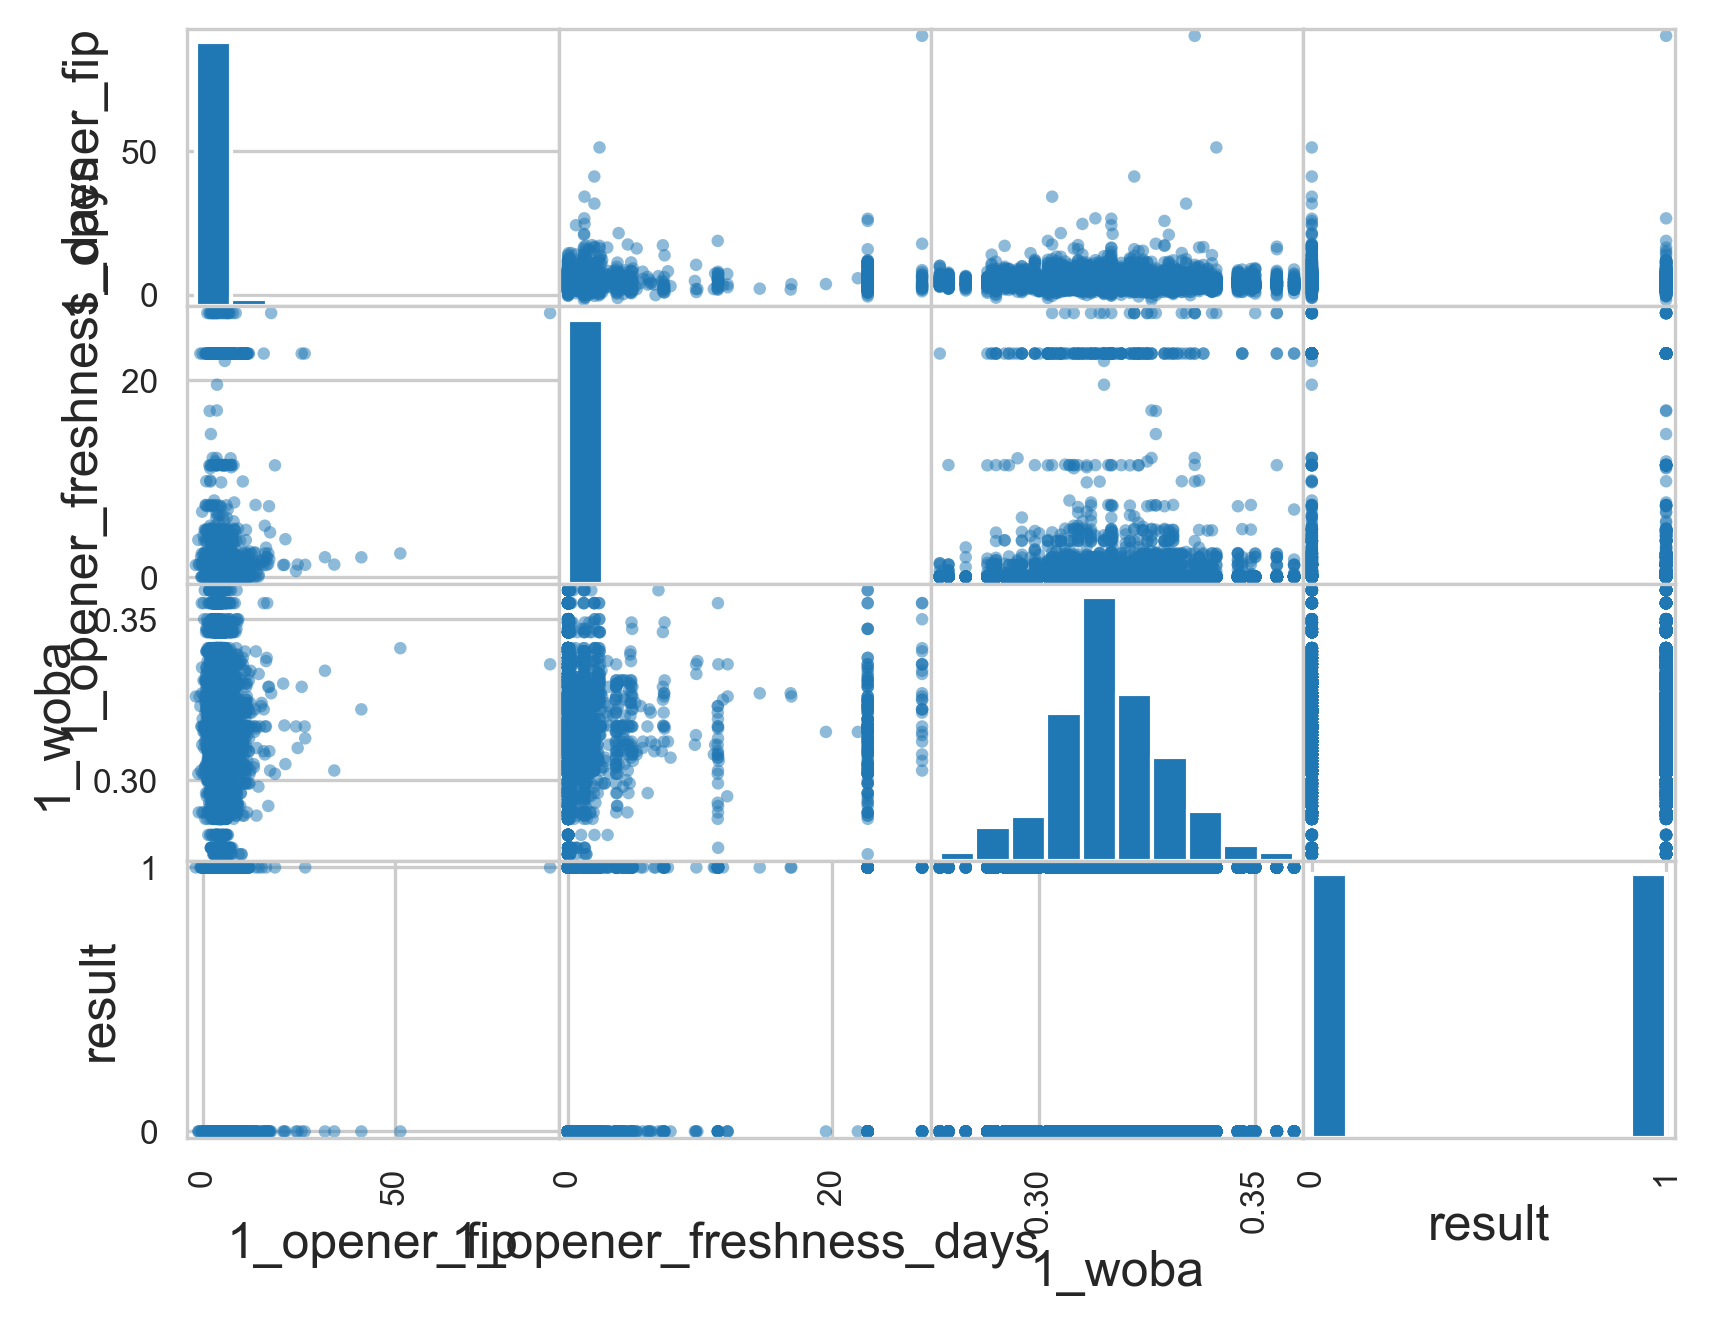

In [ ]:
# Plot scatterplots bewteen key features to inspect for patterns
pd.plotting.scatter_matrix(df[['1_opener_fip', '1_opener_freshness_days', '1_woba', 'result']])
plt.show()

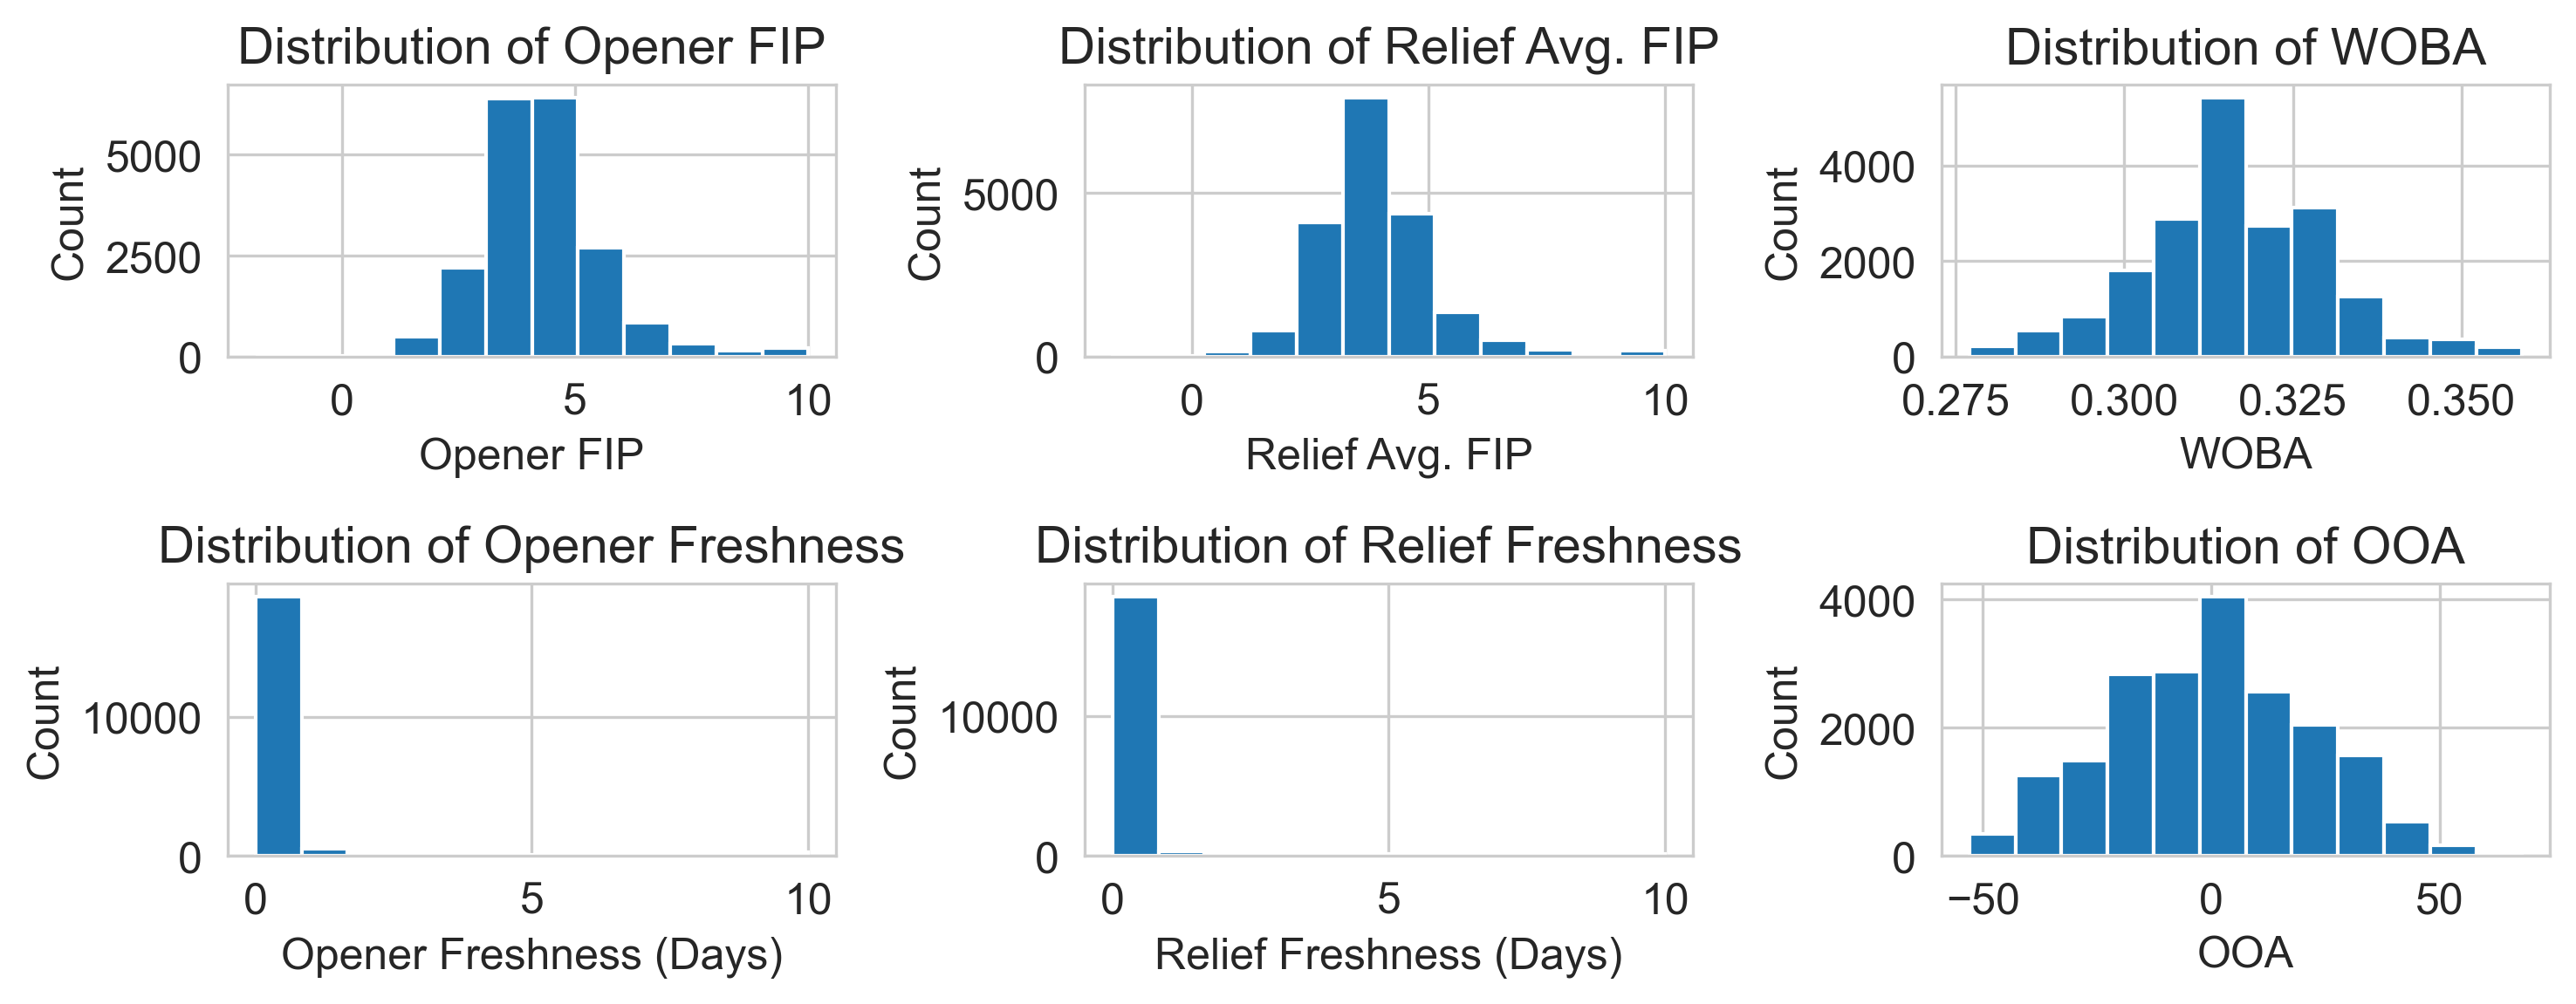

In [ ]:
# Create lists of features, titles, and xlabels for plotting purposes
features = ['1_opener_fip', '1_others_fip', '1_woba', '1_opener_freshness_days', '1_others_freshness_days', '1_ooa']
titles = ['Opener FIP', 'Relief Avg. FIP', 'WOBA', 'Opener Freshness', 'Relief Freshness', 'OOA']
xlabels = ['Opener FIP', 'Relief Avg. FIP', 'WOBA', 'Opener Freshness (Days)', 'Relief Freshness (Days)', 'OOA']

# Clip outliers to prevent skewing plots
df['1_opener_fip'] = df['1_opener_fip'].clip(upper=10)
df['1_others_fip'] = df['1_others_fip'].clip(upper=10)

df['1_opener_freshness_days'] = df['1_opener_freshness_days'].clip(upper=10)
df['1_others_freshness_days'] = df['1_others_freshness_days'].clip(upper=10)

# Create figure and ax objects
fig, axs = plt.subplots(2, 3, figsize=(10, 4))
axs = axs.ravel()

# Iterate through big zipped list to make plots
for ax, feat, title, lab in zip(axs, features, titles, xlabels):
    # Create histogram with title and labels
    df[feat].hist(bins=12, ax=ax)
    ax.set_title(f"Distribution of {title}")
    ax.set_xlabel(lab)
    ax.set_ylabel("Count")

# Fix formatting and save to figures directory, as a pdf
plt.tight_layout()
plt.savefig("Paper/figures/feature_distributions.pdf", bbox_inches="tight")

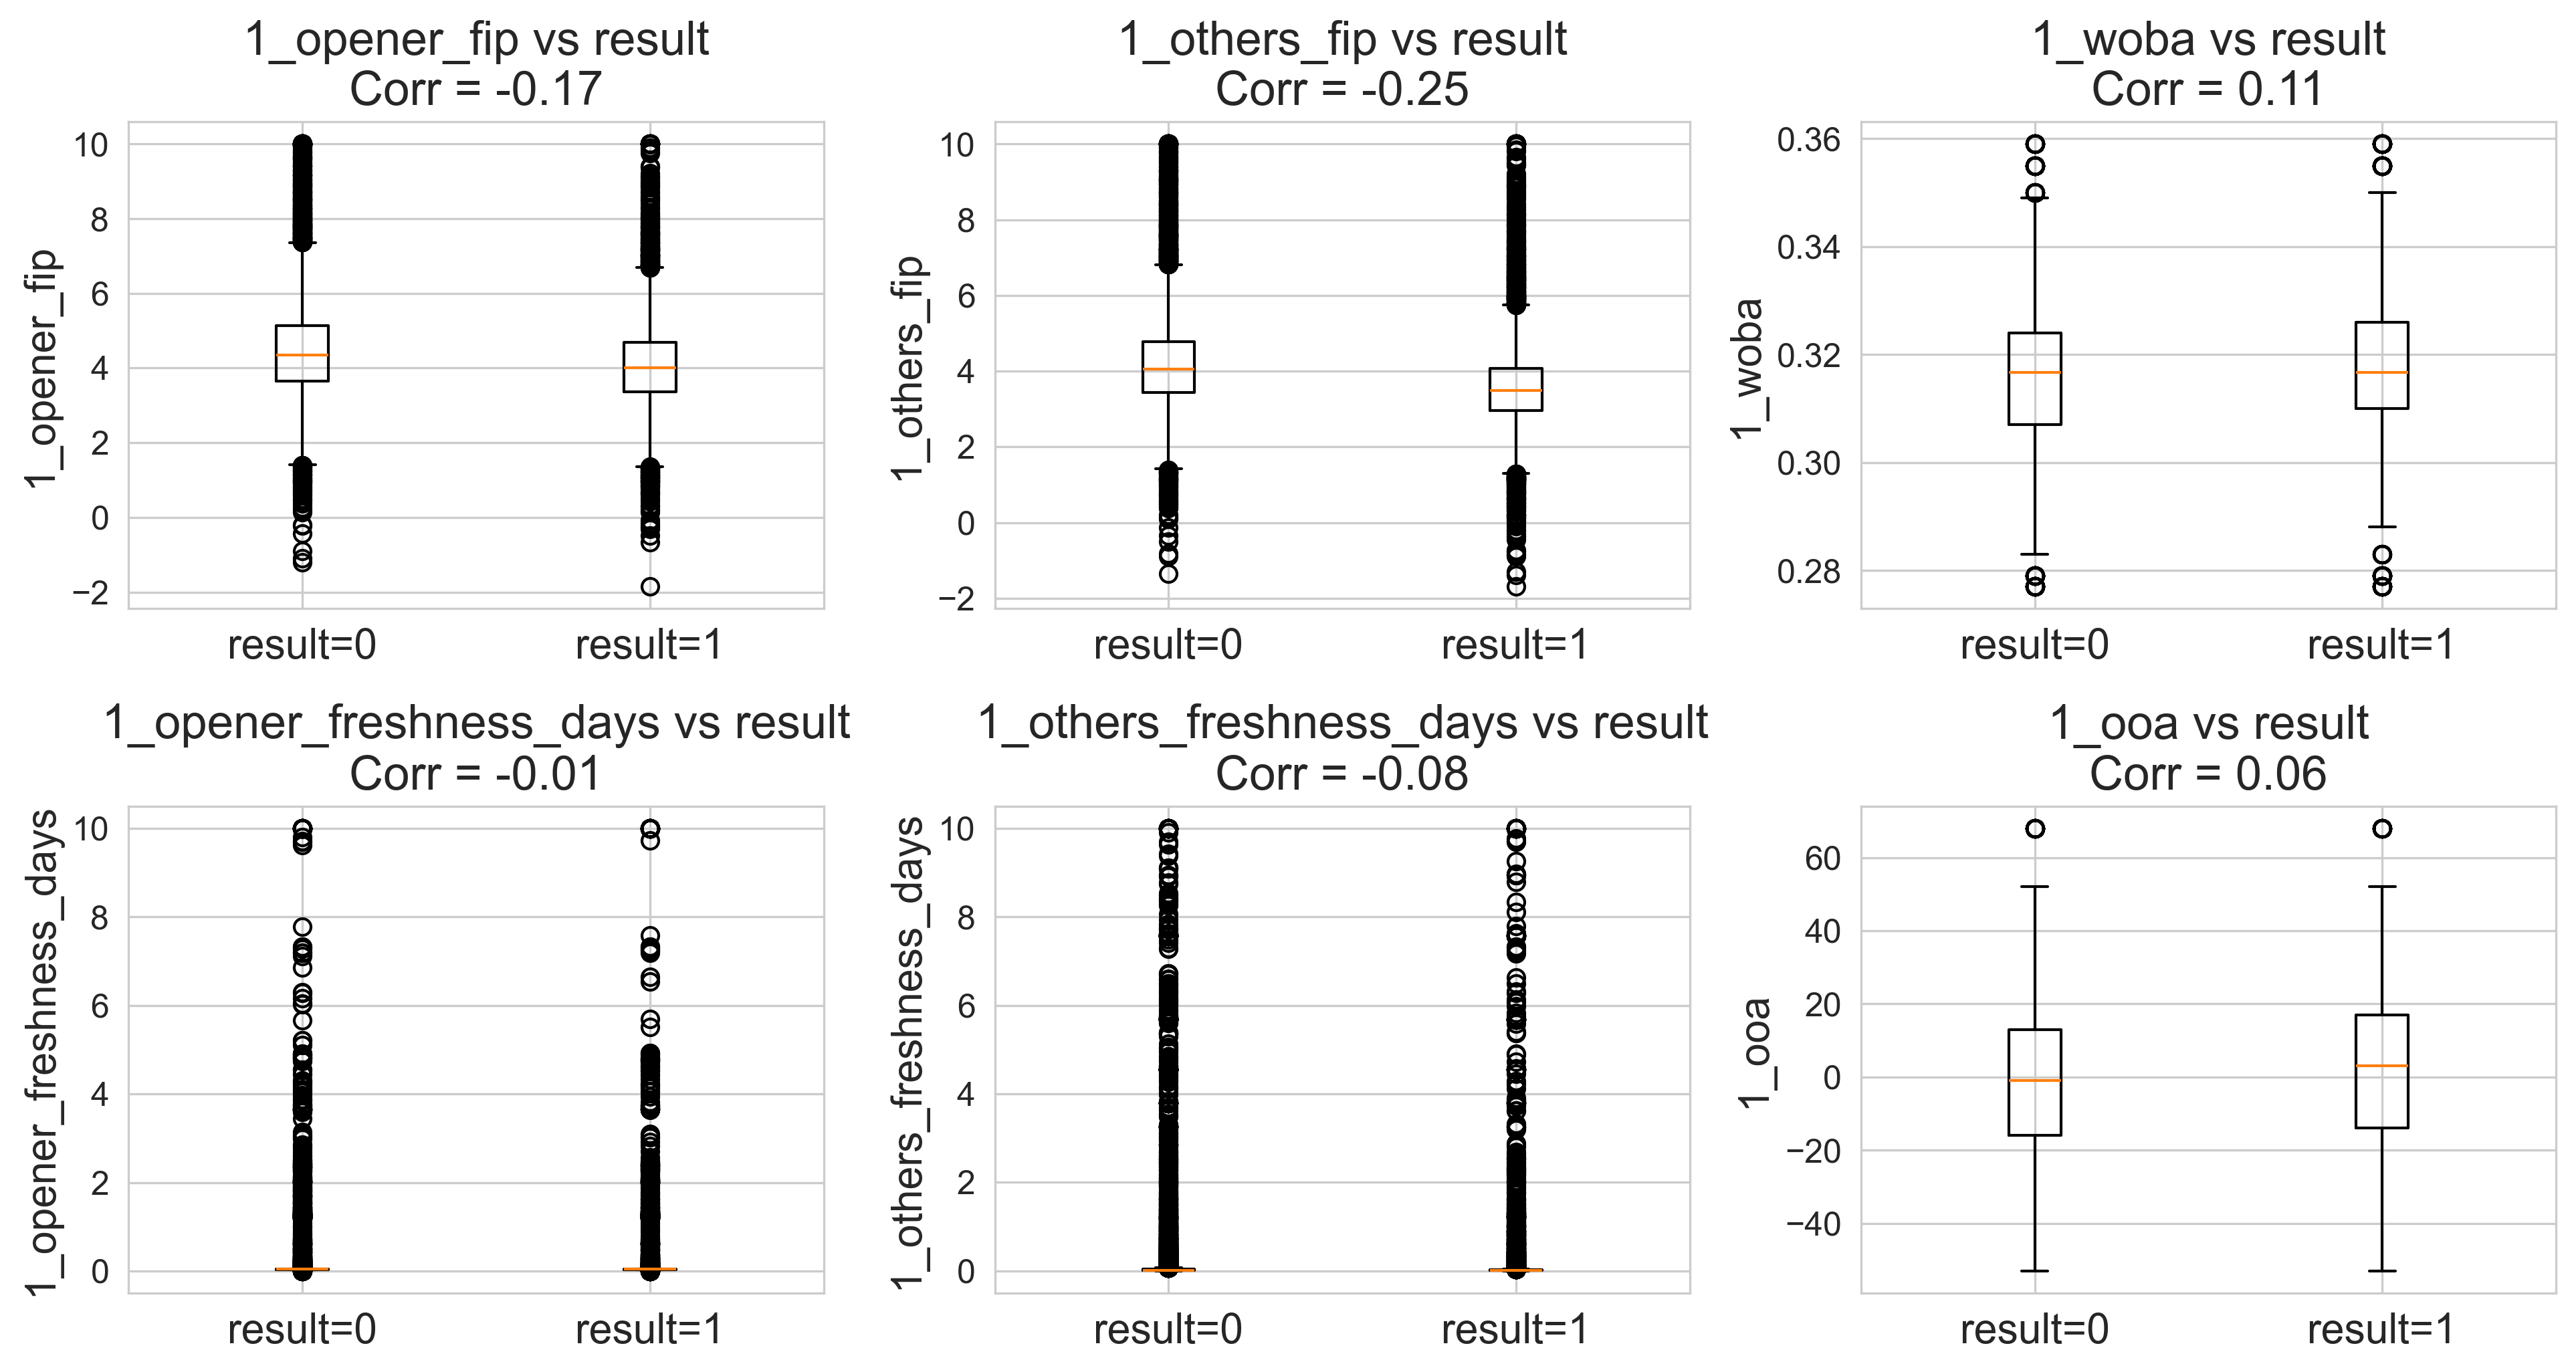

In [ ]:
# Create list of features to be plotted
features = ['1_opener_fip', '1_others_fip', '1_woba', '1_opener_freshness_days', '1_others_freshness_days', '1_ooa']

# Create figure and ax objects
fig, axs = plt.subplots(2, 3, figsize=(13, 7))
axs = axs.ravel()

# Name the target feature
target = 'result'

# Iterate through axis objects and features to plot
for ax, feat in zip(axs, features):
    # Drop NaNs for correlation and plotting
    sub = df[[feat, target]].dropna()
    
    # Compute Pearson correlation (binary since target is 0/1)
    corr = sub[[feat, target]].corr().loc[feat, target]
    
    # Prepare data for boxplot: feature values for each target class
    vals_0 = sub.loc[sub[target] == 0, feat]
    vals_1 = sub.loc[sub[target] == 1, feat]
    
    # Make boxplot
    ax.boxplot(
        [vals_0, vals_1],
        tick_labels=[f"{target}=0", f"{target}=1"],
        showfliers=True
    )

    # Set labels
    ax.set_xticklabels([f"{target}=0", f"{target}=1"], fontsize=15)
    ax.set_title(f"{feat} vs {target}\nCorr = {corr:.2f}", fontsize=17)
    ax.set_ylabel(feat, fontsize=15)

# Fix formatting and save to figures directory as a pdf
plt.tight_layout()
plt.savefig("Paper/figures/results_box_plots.pdf", bbox_inches="tight")

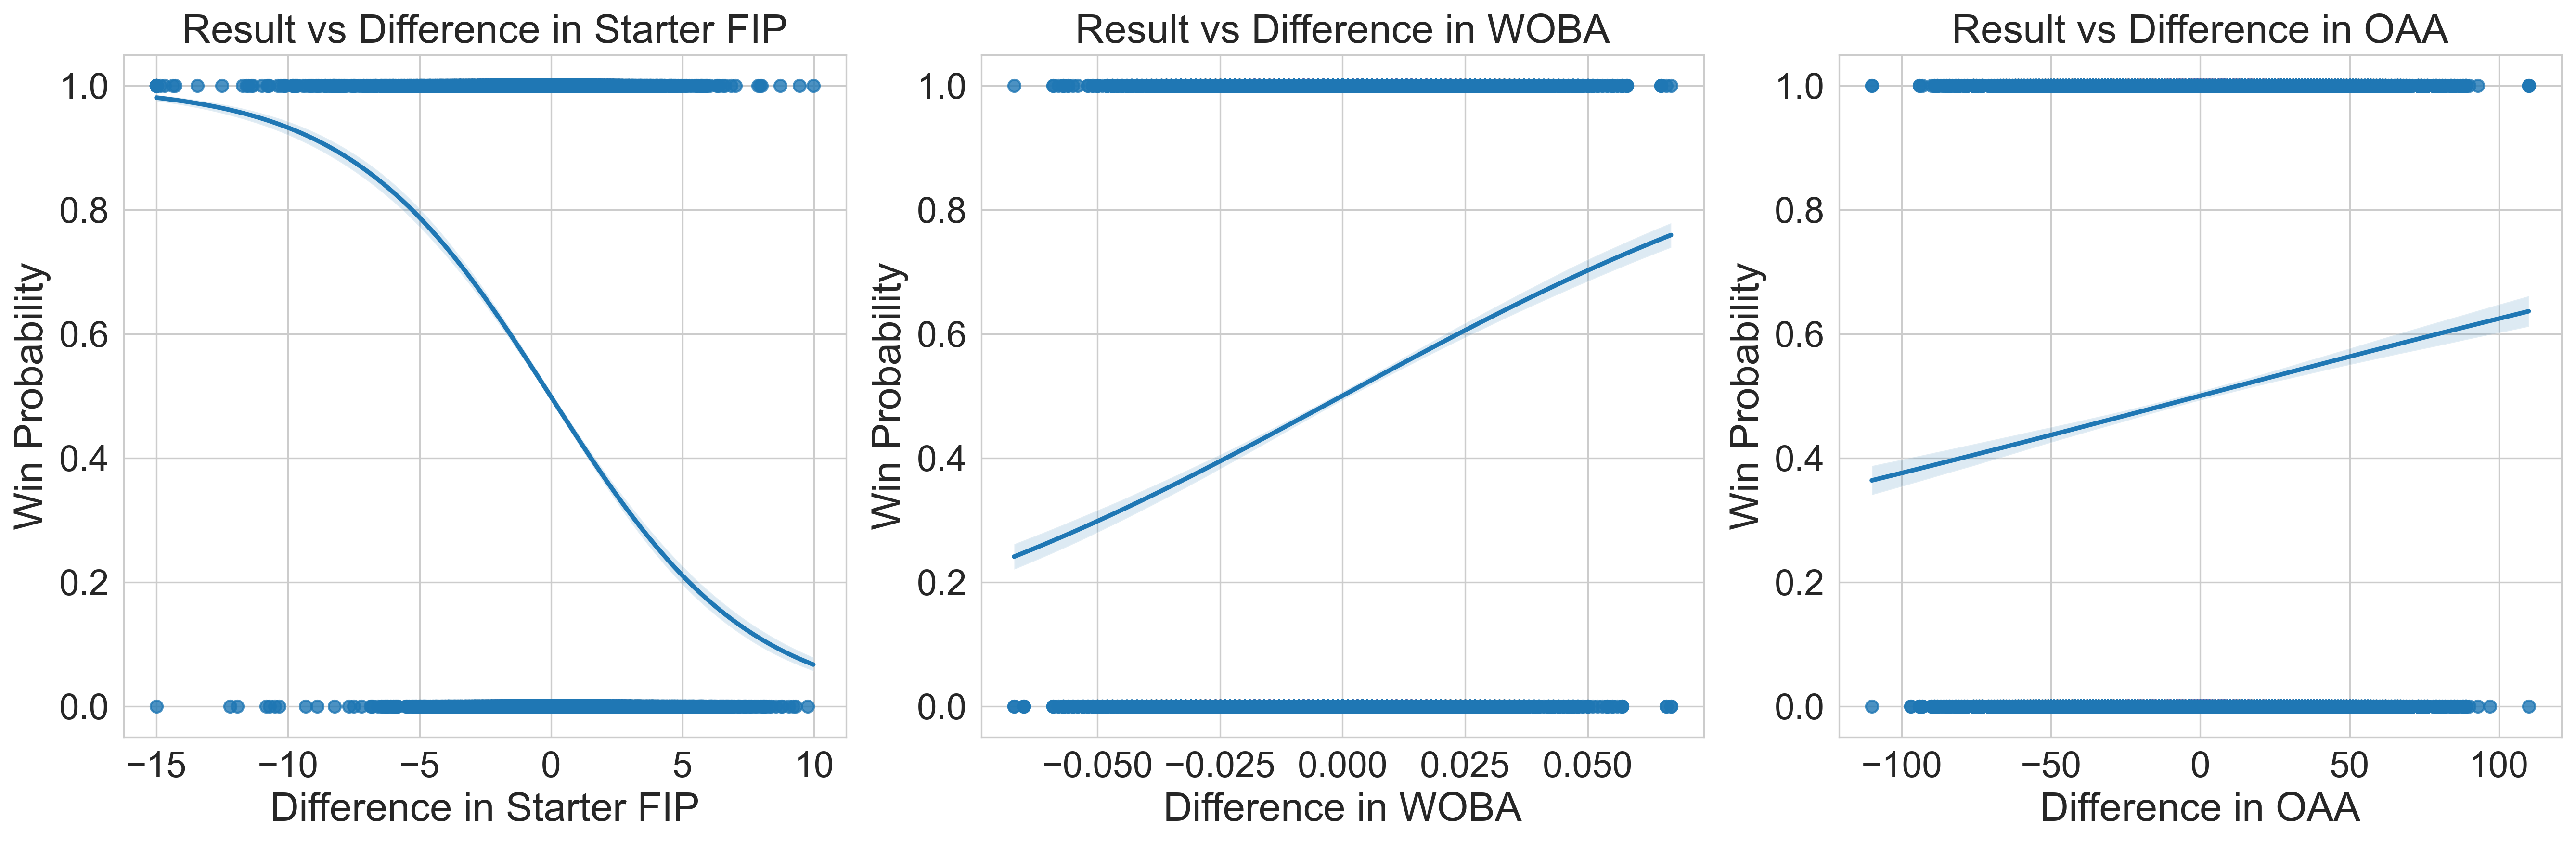

In [ ]:
# Engineer difference features and clip them to reasonable values
df['diff_opener_fip'] = df['1_opener_fip'] - df['2_opener_fip']
df['diff_opener_fip'] = df['diff_opener_fip'].clip(lower=-15, upper=15)
df['diff_opener_freshness'] = df['1_opener_freshness'] - df['2_opener_freshness']
df['diff_woba'] = df['1_woba'] - df['2_woba']
df['diff_ooa'] = df['1_ooa'] - df['w_ooa']

# Create lists of features and labels for plotting
features = ['diff_opener_fip', 'diff_woba', 'diff_ooa']
xlabels = ['Difference in Starter FIP', 'Difference in WOBA', 'Difference in OAA']

# Create figure and axis objects
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Iterate through axis objects, features, and labels to plot
for ax, feat, lab in zip(axs, features, xlabels):
    # Plot logistic curve for one feature at a time with sns.regplot()
    sns.regplot(
        x=feat,
        y=target,
        data=df,
        logistic=True,
        ax=ax
    )

    # Set labels and titles
    ax.set_xlabel(lab, fontsize=20)
    ax.set_ylabel("Win Probability", fontsize=20)
    ax.set_title(f"Result vs {lab}", fontsize=20)
    ax.tick_params(axis='both', labelsize=18)

# Fix formatting and show plot (Not included in paper)
plt.tight_layout()
plt.show()

<Figure size 2400x1500 with 0 Axes>

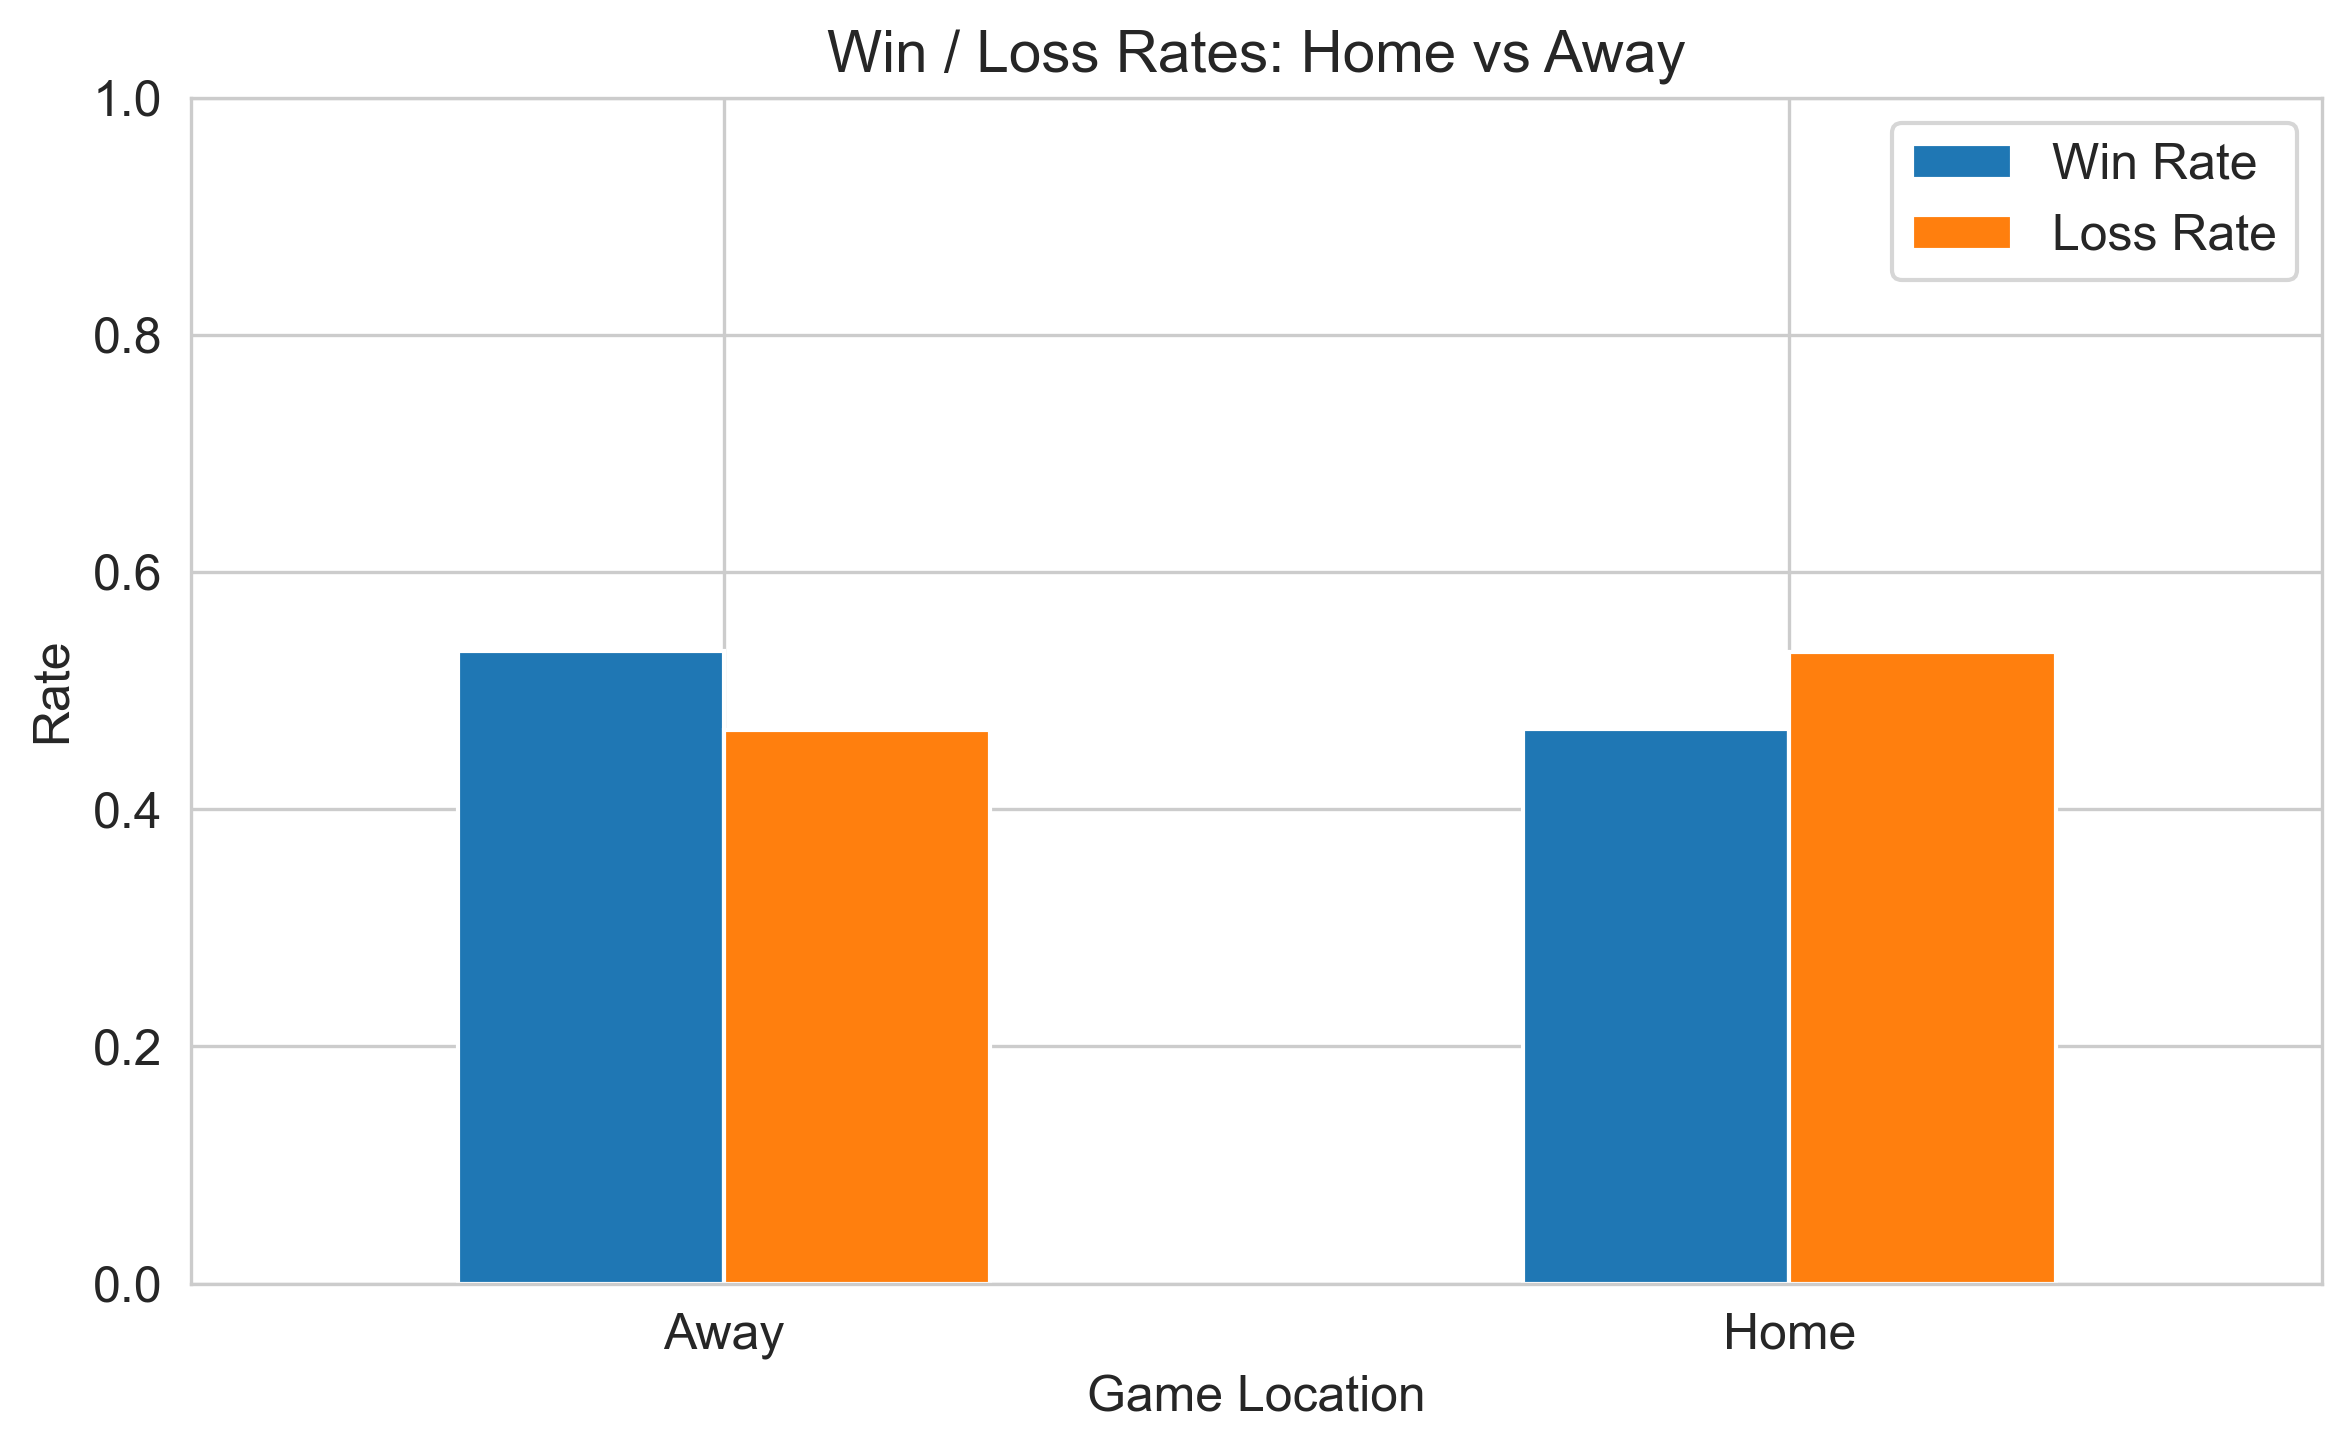

In [ ]:
# Set names for home indicator and win/lose results column
home_col = '1_home'
target = 'result'

# Create new summary df with just two rows, one for home and one for away.
# The only column is the aggregated mean. Since it's binary, it's just rate.
summary = df.groupby(home_col)[target].agg(['mean', 'count'])
summary.rename(columns={'mean': 'win_rate'}, inplace=True)

# Create loss_rate column as well
summary['loss_rate'] = 1 - summary['win_rate']

# Rename index as well to make graphing easier
summary.index = summary.index.map({0: 'Away', 1: 'Home'})

# Create figures and plot both features against the index
plt.figure(figsize=(8, 5))
summary[['win_rate', 'loss_rate']].plot(kind='bar', figsize=(8,5))

# Add title and labels
plt.title('Win / Loss Rates: Home vs Away')
plt.ylabel('Rate')
plt.xlabel('Game Location')
plt.xticks(rotation=0)
plt.legend(['Win Rate', 'Loss Rate'])
plt.ylim(0, 1)

# Show plot
plt.tight_layout()
plt.show()


In [33]:
team1_df = df[['1_team', 'result', '1_others_fip', '1_woba', '1_ooa']].copy()
team1_df.columns = ['team', 'win', 'fip', 'woba', 'ooa']
team2_df = df[['2_team', 'result', '2_others_fip', '2_woba', 'w_ooa']].copy()
team2_df.columns = ['team', 'win', 'fip', 'woba', 'ooa']
team2_df['win'] = 1 - team2_df['win']
all_teams = pd.concat([team1_df, team2_df])
team_stats = all_teams.groupby('team').agg({
    'win': ['sum', 'count', 'mean'],
    'fip': 'mean',
    'woba': 'mean',
    'ooa': 'mean'
}).round(3)
team_stats.columns = ['wins', 'games', 'win_rate', 'avg_fip', 'avg_woba', 'avg_ooa']
team_stats = team_stats.sort_values('win_rate', ascending=False)
print("Top 10 Teams by Win Rate:")
print(team_stats[team_stats['games'] >= 100].head(10))
print("\nBottom 5 Teams by Win Rate:")
print(team_stats[team_stats['games'] >= 100].tail(5))


Top 10 Teams by Win Rate:
      wins  games  win_rate  avg_fip  avg_woba  avg_ooa
team                                                   
LAD    881   1421     0.620    3.591     0.331   -4.595
HOU    835   1402     0.596    3.596     0.329   26.196
NYY    762   1341     0.568    3.500     0.328   -5.065
CLE    722   1308     0.552    3.551     0.315   15.827
MIL    737   1344     0.548    3.818     0.318   11.395
TBR    732   1337     0.547    3.878     0.318   -0.889
BOS    723   1328     0.544    3.734     0.328   -9.893
ATL    701   1294     0.542    3.791     0.326    3.913
CHC    718   1345     0.534    3.856     0.323   20.884
STL    676   1305     0.518    3.948     0.319   10.434

Bottom 5 Teams by Win Rate:
      wins  games  win_rate  avg_fip  avg_woba  avg_ooa
team                                                   
CHW    576   1292     0.446    3.943     0.308   -7.931
COL    576   1311     0.439    4.262     0.319    2.830
PIT    567   1302     0.435    4.035     0.305   

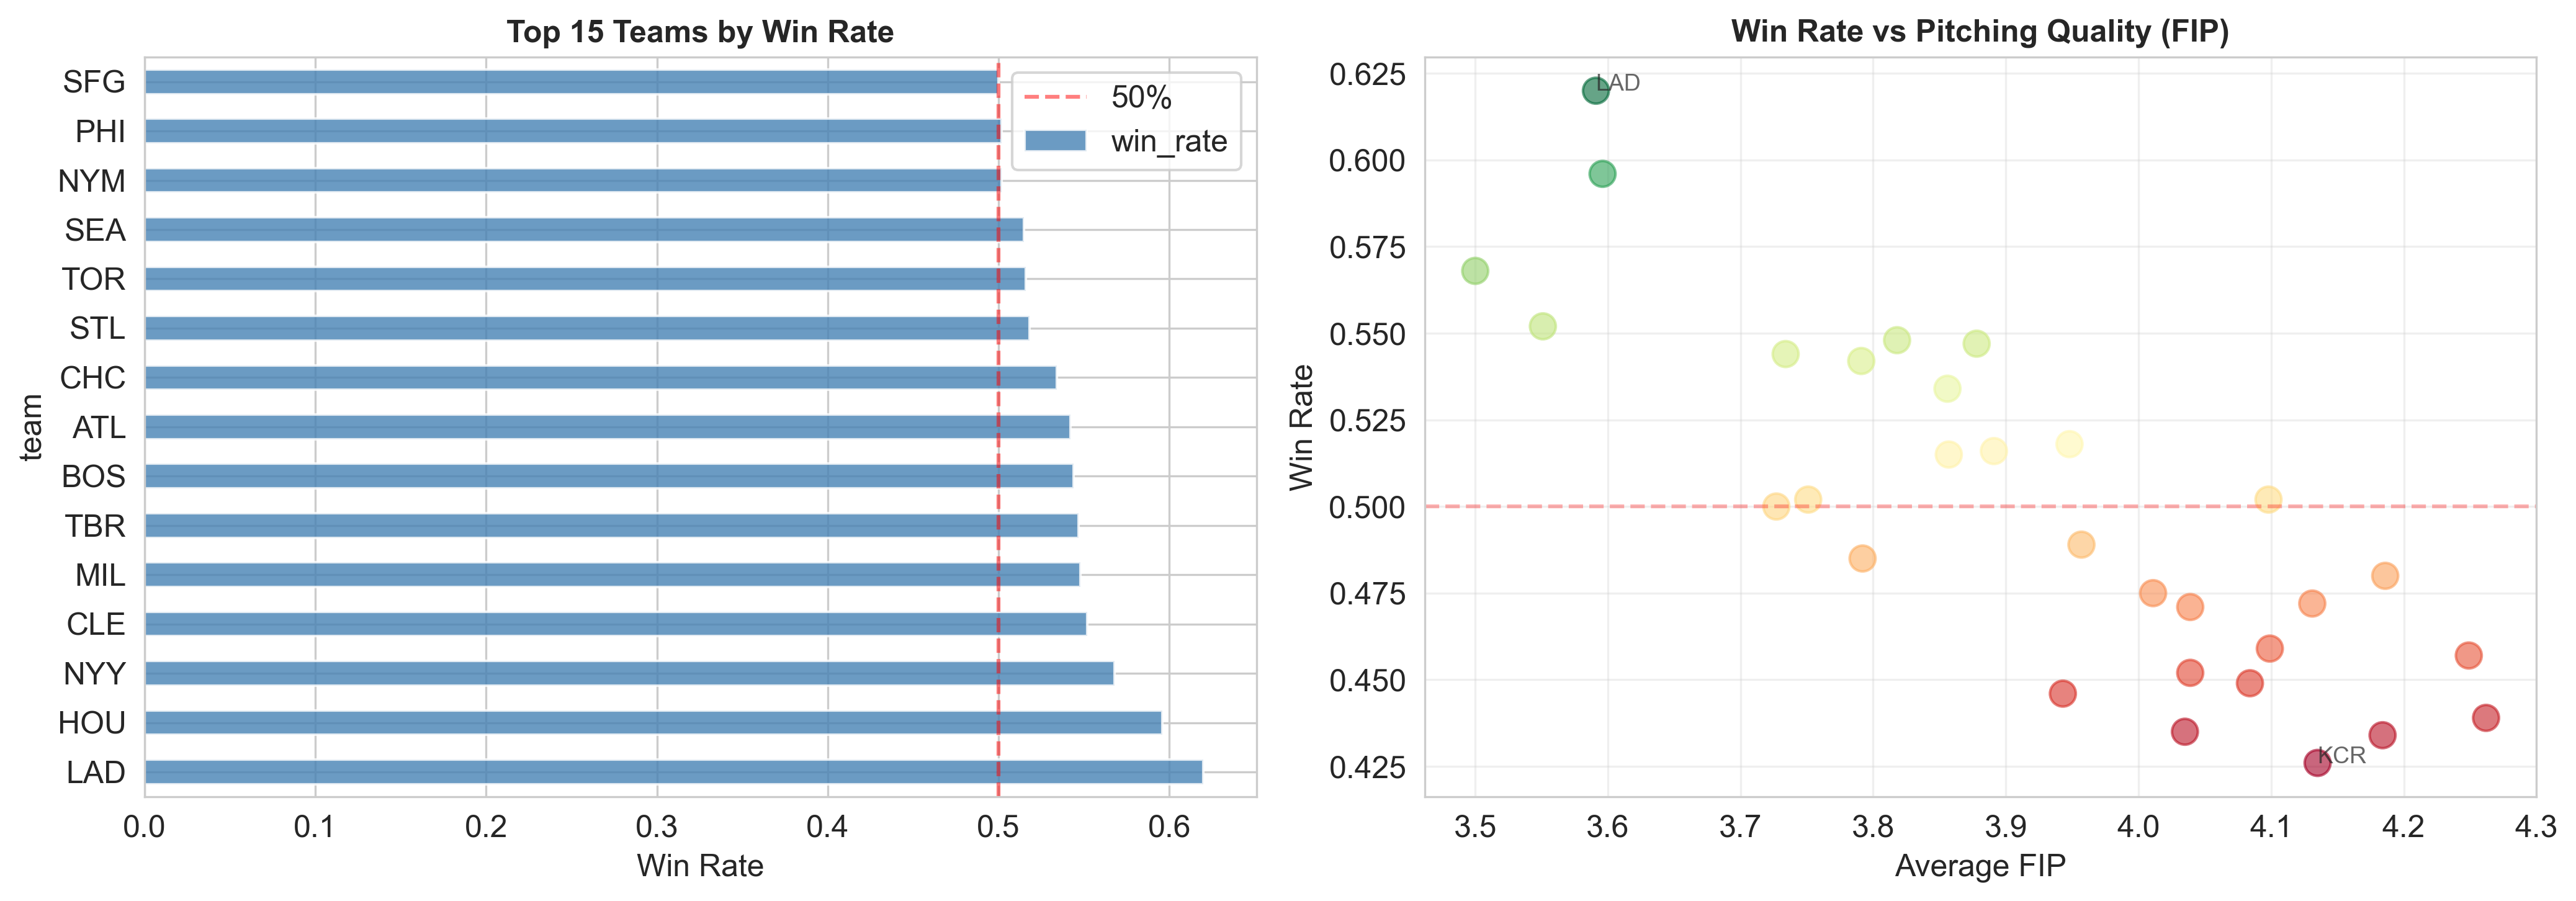

In [34]:
top_teams = team_stats[team_stats['games'] >= 100].head(15)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
top_teams['win_rate'].plot(kind='barh', ax=axes[0], color='steelblue', alpha=0.8)
axes[0].set_title('Top 15 Teams by Win Rate', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Win Rate')
axes[0].axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='50%')
axes[0].legend()
qualified_teams = team_stats[team_stats['games'] >= 100]
axes[1].scatter(qualified_teams['avg_fip'], qualified_teams['win_rate'], 
                s=100, alpha=0.6, c=qualified_teams['win_rate'], cmap='RdYlGn')
axes[1].set_xlabel('Average FIP')
axes[1].set_ylabel('Win Rate')
axes[1].set_title('Win Rate vs Pitching Quality (FIP)', fontsize=12, fontweight='bold')
axes[1].axhline(y=0.5, color='red', linestyle='--', alpha=0.3)
axes[1].grid(alpha=0.3)
for idx in [0, -1]: 
    team = qualified_teams.index[idx]
    x = qualified_teams.iloc[idx]['avg_fip']
    y = qualified_teams.iloc[idx]['win_rate']
    axes[1].annotate(team, (x, y), fontsize=9, alpha=0.7)
plt.tight_layout()
plt.show()


In [35]:
# Most common matchups
df['matchup'] = df.apply(lambda x: '_vs_'.join(sorted([x['1_team'], x['2_team']])), axis=1)
matchup_counts = df['matchup'].value_counts().head(20)

print("Top 20 Most Common Matchups:")
for i, (matchup, count) in enumerate(matchup_counts.items(), 1):
    teams = matchup.split('_vs_')
    print(f"{i:2d}. {teams[0]:3s} vs {teams[1]:3s}: {count:3d} games")


Top 20 Most Common Matchups:
 1. LAD vs SDP: 157 games
 2. HOU vs TEX: 153 games
 3. LAD vs SFG: 153 games
 4. TBR vs TOR: 150 games
 5. ARI vs COL: 149 games
 6. SEA vs TEX: 149 games
 7. NYY vs TBR: 149 games
 8. HOU vs SEA: 149 games
 9. CHC vs PIT: 149 games
10. ARI vs LAD: 149 games
11. CIN vs MIL: 149 games
12. MIL vs PIT: 148 games
13. HOU vs OAK: 148 games
14. BOS vs TOR: 147 games
15. LAA vs TEX: 147 games
16. OAK vs SEA: 147 games
17. NYY vs TOR: 147 games
18. HOU vs LAA: 147 games
19. DET vs KCR: 147 games
20. BOS vs TBR: 147 games


# Modeling

In [11]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from xgboost import XGBClassifier 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report

In [ ]:
df = pd.read_csv('data/GAMES.csv')

,game_id,1_opener_fip,1_opener_freshness,1_others_fip,1_others_freshness,1_woba,1_ooa,1_home,1_team,1_is_wildcard,2_opener_fip,2_opener_freshness,2_others_fip,2_others_freshness,2_woba,w_ooa,2_team,2_is_wildcard,is_playoff,result
0,ARI_COL_2017-10-04,3.43,17280.0,5.746000,80611.2,0.329,-2,0,ARI,0,9.91,96480.0,3.552857,66270.857143,0.332,21,COL,0,1,1
1,ARI_LAD_2017-10-06,16.16,96480.0,2.460000,61398.0,0.329,-2,1,ARI,0,10.58,8376.0,4.160000,40792.000000,0.330,-18,LAD,0,1,0
2,ARI_LAD_2017-10-07,2.71,72.0,3.926667,56.0,0.329,-2,1,ARI,0,6.66,8496.0,2.215000,18908.000000,0.330,-18,LAD,0,1,0
3,ARI_LAD_2017-10-09,3.56,8808.0,2.567500,48.0,0.330,-18,1,LAD,0,7.08,120.0,3.470000,60.000000,0.329,-2,ARI,0,1,1
4,ARI_LAD_2023-10-07,2.62,96480.0,5.735000,96.0,0.317,35,1,ARI,0,51.26,8640.0,5.926667,43600.000000,0.341,-4,LAD,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19776,TOR_WSN_2023-08-29,4.18,120.0,3.960000,96.0,0.324,9,0,TOR,0,4.66,144.0,3.706667,72.000000,0.309,-2,WSN,0,0,0
19777,TOR_WSN_2023-08-30,5.11,144.0,5.475000,48.0,0.309,-2,1,WSN,0,4.56,120.0,4.460000,72.000000,0.324,9,TOR,0,0,0
19778,TOR_WSN_2025-03-31,7.64,13536.0,1.600000,48.0,0.330,20,0,TOR,0,5.14,6876.0,9.640000,33.600000,0.302,-33,WSN,0,0,1
19779,TOR_WSN_2025-04-01,5.76,120.0,5.900000,20460.0,0.330,20,0,TOR,0,1.94,13200.0,7.363333,40.000000,0.302,-33,WSN,0,0,1


Random Forest with all data

In [18]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report

# features and target 
X, y = df.drop(columns=['game_id', '1_team', '2_team', 'result']), df['result']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# fit model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# f1 
pred_test = rf.predict(X_test)
og_f1_test = f1_score(y_test, pred_test, average='weighted')
print(f"F1 score: {og_f1_test:.4f}")

# CM
CM_test = confusion_matrix(y_test, pred_test) 
print("\nConfusion Matrix:")
print(CM_test)
print("\nClassification Report:")
print(classification_report(y_test, pred_test))


F1 score: 0.7058

Confusion Matrix:
[[1727  715]
 [ 740 1764]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.71      0.70      2442
           1       0.71      0.70      0.71      2504

    accuracy                           0.71      4946
   macro avg       0.71      0.71      0.71      4946
weighted avg       0.71      0.71      0.71      4946



In [19]:
# RF
print("=" * 80)
print("Random Forest Grid Search")
print("=" * 80)

# param grid 
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# base rf 
rf_base = RandomForestClassifier(random_state=42)

# grid search
rf_grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=rf_param_grid,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1,
    verbose=1
)

rf_grid_search.fit(X_train, y_train)

print("\n" + "=" * 80)
print("Best Parameters:")
print("=" * 80)
for param, value in rf_grid_search.best_params_.items():
    print(f"  {param}: {value}")


# f1 score of best rf 
best_rf = rf_grid_search.best_estimator_
pred_best_rf = best_rf.predict(X_test)
f1_best_rf = f1_score(y_test, pred_best_rf, average='weighted')
print(f"\nBest Random Forest F1 score: {f1_best_rf:.4f}")
print(f"Default Random Forest F1 score: {og_f1_test:.4f}")
print(f"Improvement over default: {f1_best_rf - og_f1_test:.4f}")

# CM for best rf 
CM_best_rf = confusion_matrix(y_test, pred_best_rf)
print("\nBest Random Forest Confusion Matrix:")
print(CM_best_rf)
print("\nBest Random Forest Classification Report:")
print(classification_report(y_test, pred_best_rf))


Random Forest Grid Search
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Best Parameters:
  max_depth: 30
  max_features: sqrt
  min_samples_leaf: 2
  min_samples_split: 10
  n_estimators: 200

Best Random Forest F1 score: 0.7072
Default Random Forest F1 score: 0.7058
Improvement over default: 0.0014

Best Random Forest Confusion Matrix:
[[1710  732]
 [ 716 1788]]

Best Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70      2442
           1       0.71      0.71      0.71      2504

    accuracy                           0.71      4946
   macro avg       0.71      0.71      0.71      4946
weighted avg       0.71      0.71      0.71      4946



XGBoost with all data 

In [ ]:
# XGBoost
print("=" * 80)
print("XGBoost Model")
print("=" * 80)

# Fit
xgb = XGBClassifier(random_state=42, eval_metric='logloss')
xgb.fit(X_train, y_train)

# f1 
pred_xgb = xgb.predict(X_test)
f1_xgb = f1_score(y_test, pred_xgb, average='weighted')
print(f"\nXGBoost F1 score: {f1_xgb:.4f}")
print(f"Random Forest F1 score: {og_f1_test:.4f}")
print(f"Difference: {f1_xgb - og_f1_test:.4f}")

# CM
CM_xgb = confusion_matrix(y_test, pred_xgb)
print("\nXGBoost Confusion Matrix:")
print(CM_xgb)
print("\nXGBoost Classification Report:")
print(classification_report(y_test, pred_xgb))


In [ ]:
# XGBoost Grid Search
print("=" * 80)
print("XGBoost Grid Search")
print("=" * 80)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_base = XGBClassifier(random_state=42, eval_metric='logloss')

grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"Best CV F1 Score: {grid_search.best_score_:.4f}")

best_xgb = grid_search.best_estimator_
pred_best_xgb = best_xgb.predict(X_test)

xgb_default = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_default.fit(X_train, y_train)
pred_xgb_default = xgb_default.predict(X_test)
f1_xgb = f1_score(y_test, pred_xgb_default, average='weighted')


Feature importance 

In [16]:
print("=" * 80)
print("Regular Season vs Post Season")
print("=" * 80)

print(f"\nTotal games: {len(df)}")
print(f"Regular season games: {len(df[df['is_playoff'] == 0])}")
print(f"Post season games: {len(df[df['is_playoff'] == 1])}")


df_regular = df[df['is_playoff'] == 0].copy()
df_postseason = df[df['is_playoff'] == 1].copy()

print(f"\nRegular season shape: {df_regular.shape}")
print(f"Post season shape: {df_postseason.shape}")

feature_cols = [col for col in df.columns if col not in ['game_id', '1_team', '2_team', 'result', 'is_playoff']]
print(f"\nNumber of features: {len(feature_cols)}")
print(f"Features: {feature_cols}")

Regular Season vs Post Season

Total games: 19781
Regular season games: 19464
Post season games: 317

Regular season shape: (19464, 20)
Post season shape: (317, 20)

Number of features: 15
Features: ['1_opener_fip', '1_opener_freshness', '1_others_fip', '1_others_freshness', '1_woba', '1_ooa', '1_home', '1_is_wildcard', '2_opener_fip', '2_opener_freshness', '2_others_fip', '2_others_freshness', '2_woba', 'w_ooa', '2_is_wildcard']


In [12]:
print("=" * 80)
print("Feature Importance: Regular Season")
print("=" * 80)

X_regular = df_regular[feature_cols].copy()
y_regular = df_regular['result'].copy()

# imputation 
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
X_regular_imputed = pd.DataFrame(
    imputer.fit_transform(X_regular),
    columns=X_regular.columns,
    index=X_regular.index
)


X_regular_train, X_regular_test, y_regular_train, y_regular_test = train_test_split(
    X_regular_imputed, y_regular, test_size=0.2, random_state=42
)

# XGBoost 
xgb_regular = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    n_estimators=200,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=1.0
)
xgb_regular.fit(X_regular_train, y_regular_train)

# Get feature importance
feature_importance_regular = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_regular.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(feature_importance_regular.head(15).to_string(index=False))

# evaluation
pred_regular = xgb_regular.predict(X_regular_test)
f1_regular = f1_score(y_regular_test, pred_regular, average='weighted')
print(f"\nRegular Season XGBoost F1 Score: {f1_regular:.4f}")

Feature Importance: Regular Season

Top 15 Most Important Features:
           feature  importance
      1_others_fip    0.241036
      2_others_fip    0.222969
1_others_freshness    0.084393
2_others_freshness    0.081908
      2_opener_fip    0.071076
            1_home    0.063928
      1_opener_fip    0.058401
            2_woba    0.044060
            1_woba    0.042821
             1_ooa    0.023941
             w_ooa    0.023420
2_opener_freshness    0.022333
1_opener_freshness    0.019714
     1_is_wildcard    0.000000
     2_is_wildcard    0.000000

Regular Season XGBoost F1 Score: 0.6964


In [17]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report

X_regular = df_regular[feature_cols].copy()
y_regular = df_regular['result'].copy()

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
X_regular_imputed = pd.DataFrame(
    imputer.fit_transform(X_regular),
    columns=X_regular.columns,
    index=X_regular.index
)

print("=" * 80)
print("Feature Importance: Post Season")
print("=" * 80)

X_postseason = df_postseason[feature_cols].copy()
y_postseason = df_postseason['result'].copy()

# missing values 
X_postseason_imputed = pd.DataFrame(
    imputer.transform(X_postseason),
    columns=X_postseason.columns,
    index=X_postseason.index
)

# split postseason data 
X_postseason_train, X_postseason_test, y_postseason_train, y_postseason_test = train_test_split(
        X_postseason_imputed, y_postseason, test_size=0.2, random_state=42
    )

# Train XGBoost on postseason data
xgb_postseason = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    n_estimators=200,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=1.0
)
xgb_postseason.fit(X_postseason_train, y_postseason_train)

# get feature importance
feature_importance_postseason = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_postseason.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features (Post Season):")
print(feature_importance_postseason.head(15).to_string(index=False))

# evaluate model

pred_postseason = xgb_postseason.predict(X_postseason_test)
f1_postseason = f1_score(y_postseason_test, pred_postseason, average='weighted')
print(f"\nPost Season XGBoost F1 Score: {f1_postseason:.4f}")


Feature Importance: Post Season

Top 15 Most Important Features (Post Season):
           feature  importance
      2_opener_fip    0.118091
      1_others_fip    0.087626
      2_others_fip    0.086408
            2_woba    0.078724
      1_opener_fip    0.078283
1_others_freshness    0.073588
             w_ooa    0.071935
2_others_freshness    0.062572
            1_home    0.059622
            1_woba    0.054027
             1_ooa    0.051832
2_opener_freshness    0.051824
1_opener_freshness    0.049794
     2_is_wildcard    0.045859
     1_is_wildcard    0.029816

Post Season XGBoost F1 Score: 0.7334


feature importance


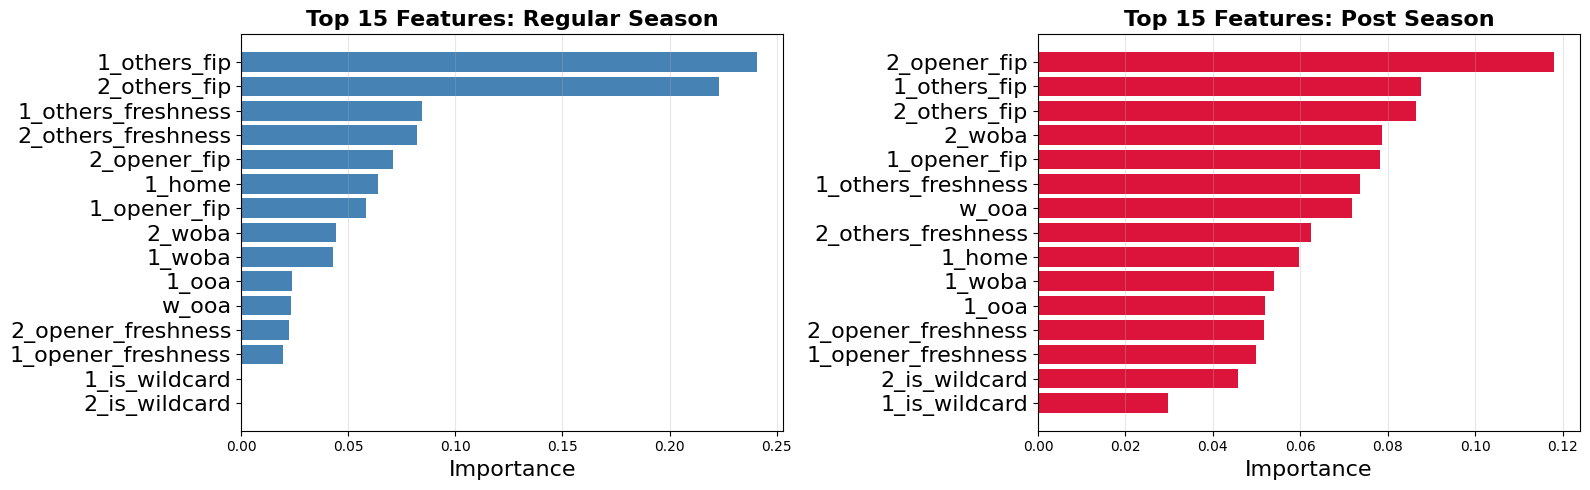

In [14]:
print("=" * 80)
print("feature importance")
print("=" * 80)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1
top_n = 15
ax1 = axes[0]
top_regular = feature_importance_regular.head(top_n)
ax1.barh(range(len(top_regular)), top_regular['importance'], color='steelblue')
ax1.set_yticks(range(len(top_regular)))
ax1.set_yticklabels(top_regular['feature'], fontsize=16)
ax1.set_xlabel('Importance', fontsize=16)
ax1.set_title(f'Top {top_n} Features: Regular Season', fontsize=16, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Plot 2
ax2 = axes[1]
top_postseason = feature_importance_postseason.head(top_n)
ax2.barh(range(len(top_postseason)), top_postseason['importance'], color='crimson')
ax2.set_yticks(range(len(top_postseason)))
ax2.set_yticklabels(top_postseason['feature'], fontsize=16)
ax2.set_xlabel('Importance', fontsize=16)
ax2.set_title(f'Top {top_n} Features: Post Season', fontsize=16, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('Paper/figures/Top15.pdf')

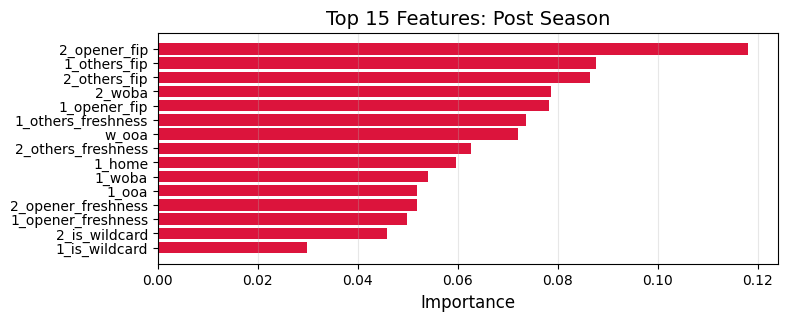

In [15]:
top_postseason = feature_importance_postseason.head(top_n)
plt.figure(figsize=(8, 3))

plt.barh(range(len(top_postseason)), top_postseason['importance'], color='crimson')

# Set tick positions AND their labels in one call
plt.yticks(
    range(len(top_postseason)),
    top_postseason['feature']
)

plt.xlabel('Importance', fontsize=12)
plt.title(f'Top {top_n} Features: Post Season', fontsize=14)

plt.gca().invert_yaxis()   # invert y-axis using the current axis
plt.grid(axis='x', alpha=0.3)

plt.savefig("Paper/figures/features_importance.pdf", bbox_inches="tight")